![enunciado](enunciado.png)

### I) Modelo médio de grandes sinais utilizando "PWM Switch Modeling"

Para realizar a modelagem média PWM das chaves é necessário sintetizar todas as etapas de operações do circuito considerado ao longo de um período de comutação.

As tabelas abaixo indicam tensões e correntes de cada semicondutor em ambas as etapas:

---

#### Chave $S_1$  fechada

| Primeira etapa    | Tensão    | Corrente          |
|-------------------|-----------|-------------------|
| $D_1$             | $-v_{C1}$ | $0$               |
| $D_2$             | $0$       | $i_{L1}$          |
| $D_3$             | $-v_o$    | $0$               |
| $S_1$             | $0$       | $i_{L1}+i_{L2}$   |
---

#### Chave $S_1$ aberta


| Segunda etapa     | Tensão        | Corrente  |
|-------------------|---------------|-----------|
| $D_1$             | $0$           | $i_{L1}$  |
| $D_2$             | $v_{C1}-v_o$  | $0$       |
| $D_3$             | $0$           | $i_{L2}$  |
| $S_1$             | $v_o$         | $0$       |
---

Optou-se por modelar os semicondutores como fontes dependentes de acordo com a tabela da segunda etapa de operação. Como as grandezas se alternam entre $0$ e uma combinação linear dos valores médios das variáveis de estado, as fontes controladas serão definidas com esses mesmos valores ponderados pela razão cíclica considerada $(1-d)$, ou seja:

#### $i_{D_1} = (1-d) i_{L1}$
#### $v_{D_2} = (1-d) (v_{C1}-v_o)$
#### $i_{D_3} = (1-d) i_{L2}$
#### $v_{S_1} = (1-d) v_o$

O diagrama elétrico equivalente resultante está ilustrado na figura abaixo.

![sch](MMGS_PWM_MODEL.png)

In [215]:
from matplotlib import pyplot as plt
import control as ctl
import numpy as np
import sympy as sp

In [207]:

s                               = sp.symbols("s")
L1, L2, C1, C2, R               = sp.symbols("L_1, L_2, C_1, C_2, R")
IL1, IL2, VC1, Vo, D            = sp.symbols("I_{L1}, I_{L2}, V_{C1}, V_o, D")
iL1, iL2, vC1, vo, d            = sp.symbols("i_{L1}, i_{L2}, v_{C1}, v_o, d")

eq1 = sp.Eq(s*L1*iL1,                          -vC1*(1-D)              +d*VC1)
eq2 = sp.Eq(s*L2*iL2,                           vC1        -vo*(1-D)   +d*Vo)
eq3 = sp.Eq(s*C1*vC1,   iL1*(1-D)  -iL2                                -d*IL1)
eq4 = sp.Eq(s*C2*vo,                iL2*(1-D)              -vo/R       -d*IL2)
display(eq1, eq2, eq3, eq4)

Eq(L_1*i_{L1}*s, V_{C1}*d - v_{C1}*(1 - D))

Eq(L_2*i_{L2}*s, V_o*d - v_o*(1 - D) + v_{C1})

Eq(C_1*s*v_{C1}, -I_{L1}*d + i_{L1}*(1 - D) - i_{L2})

Eq(C_2*s*v_o, -I_{L2}*d + i_{L2}*(1 - D) - v_o/R)

In [208]:

# Isolar iL1 na equação 1
iL1_isol = sp.solve(eq1, iL1)[0]

# Substituir iL1 na equação 3
eq3_subs = eq3.subs(iL1, iL1_isol)
# Isolar vC1 na equação 3
vC1_isol = sp.solve(eq3_subs, vC1)[0]

# Substituir vC1 na equação 2
eq2_subs = eq2.subs(vC1, vC1_isol)
# Isolar iL2 na equação 2
iL2_isol = sp.solve(eq2_subs, iL2)[0]


# Substituir iL2 na equação 4
eq4_subs = eq4.subs(iL2, iL2_isol)
# Isolar vo na equação 4
vo_isol = sp.solve(eq4_subs, vo)[0]

# A função de transferência vo/d é obtida dividindo a expressão por d
tf = vo_isol/d
# Agregar os termos multiplicados pelas mesmas potências de s
tf = tf.collect(s)
print("vo(s)/d(s) = "); display(tf)


vo(s)/d(s) = 


R*(-C_1*I_{L2}*L_1*L_2*s**3 + D**2*V_{C1} - D*V_o*(D - 1)**2 - 2*D*V_{C1} + V_o*(D - 1)**2 + V_{C1} + s**2*(-C_1*D*L_1*V_o + C_1*L_1*V_o) + s*(D*I_{L1}*L_1 - I_{L1}*L_1 - I_{L2}*L_1 - I_{L2}*L_2*(D - 1)**2))/(C_1*C_2*L_1*L_2*R*s**4 + C_1*L_1*L_2*s**3 + D**2*R*(D - 1)**2 - 2*D*R*(D - 1)**2 + R*(D - 1)**2 + s**2*(C_1*D**2*L_1*R - 2*C_1*D*L_1*R + C_1*L_1*R + C_2*L_1*R + C_2*L_2*R*(D - 1)**2) + s*(L_1 + L_2*(D - 1)**2))

In [209]:
tf_subs = tf.subs(R, 50).subs(L1, 1e-3).subs(L2, 100e-6).subs(C1, 2e-6).subs(C2, 20e-6)\
            .subs(D, 0.55).subs(Vo, 235).subs(IL1, 23.2).subs(IL2, 10.5).subs(VC1, 105.6)
tf_subs


50*(-2.1e-12*s**3 + 2.115e-7*s**2 - 0.021152625*s + 42.798375)/(2.0e-16*s**4 + 2.0e-13*s**3 + 1.0405e-6*s**2 + 0.00102025*s + 2.0503125)

In [210]:
numerator, denominator = tf_subs.as_numer_denom()
num, den = sp.Poly(numerator).all_coeffs(), sp.Poly(denominator).all_coeffs()

for i, _n in enumerate(num):
    num[i] = float(num[i])

for i, _d in enumerate(den):
    den[i] = float(den[i])

tf_ctl = ctl.TransferFunction(num, den)
tf_ctl

TransferFunction(array([-1.05000000e-10,  1.05750000e-05, -1.05763125e+00,  2.13991875e+03]), array([2.0000000e-16, 2.0000000e-13, 1.0405000e-06, 1.0202500e-03,
       2.0503125e+00]))

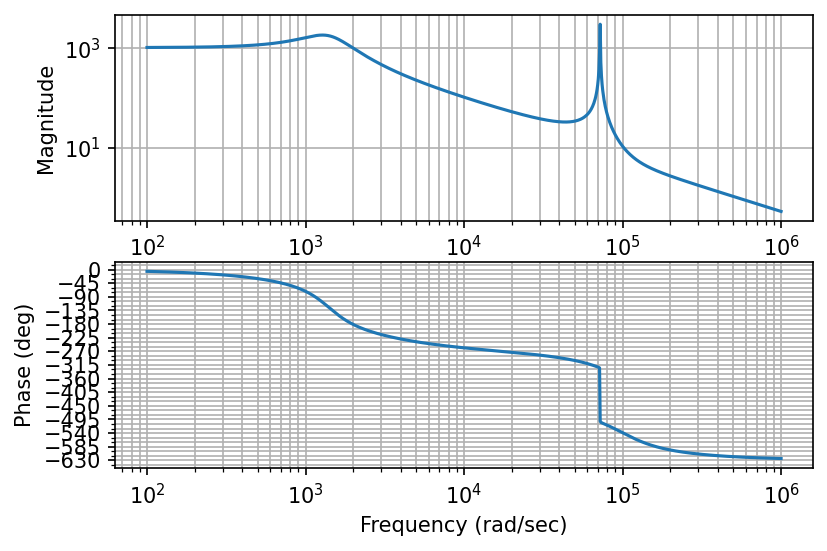

In [213]:
plt.figure(dpi=150)
ctl.bode_plot(tf_ctl);

/home/eduardo/.local/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning: Ill-conditioned matrix (rcond=6.09441e-21): result may not be accurate.
  return solve(Q, P)


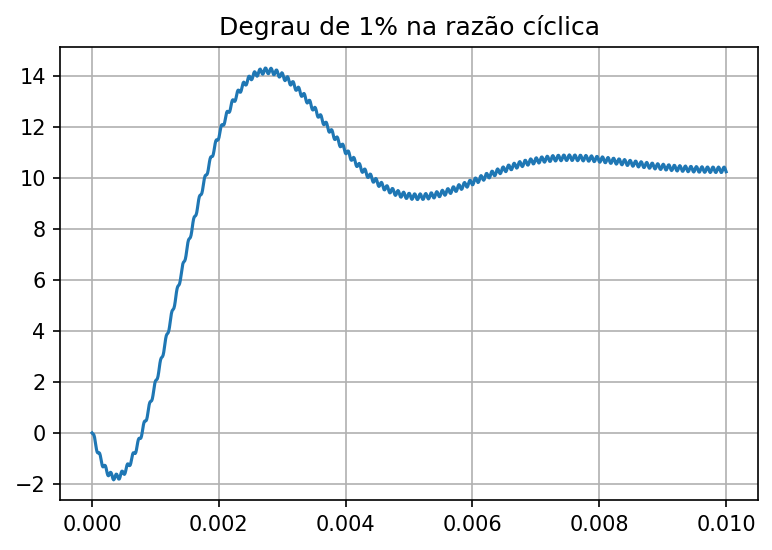

In [236]:
plt.figure(dpi=150)

t=np.linspace(0,10e-3, 1000)
# x=np.ones(t.shape)/100

_, x = ctl.step_response(tf_ctl,T=t, X0=0 );
plt.plot(t,x/100); plt.grid(True)
plt.title("Degrau de 1% na razão cíclica");